# Dataset Preparation

## Load data

In [ ]:
!pip install imbalanced-learn


In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
from scipy.signal import find_peaks
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from imblearn.over_sampling  import SMOTE, SMOTENC

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

In [2]:
def load_kawa(path):
    """
    Load file with 10-channel data from electronic nose.
    path: google drive path to the .txt file with data.
    Return: list containing 10 lists with separate data channels.
    """
    kawa_lines = []
    with open(path) as my_file:
        for line in my_file:
            kawa_lines.extend(list(line.split('INTCHAN,')))

    kawa_lines_2 = [ item for item in kawa_lines  if item != '\n' ]
    # [[i] for i in kawa_lines_2]
    # kawa_df = pd.DataFrame(bbb, columns=['Value', 'Time', 'Date', 'RDNG', 'Channel'])
    kawa_df = pd.DataFrame(kawa_lines_2, columns=['Value'])
    kawa_df[['Value', 'Time', 'Date', 'RDNG', 'Channel']] = kawa_df['Value'].str.split(',',expand=True)
    kawa_df[['Value', 'OHM4W']] = kawa_df['Value'].str.split('OHM4W',expand=True)
    kawa_df['Value'] = kawa_df['Value'].map(lambda x: float(x))

    list_of_dfs = []
    for i in range (10):
        list_of_dfs.append(kawa_df[kawa_df['Channel'] == str(101 + i)])

    list_of_channels = []
    for i in range (10):
        list_of_channels.append(list_of_dfs[i]['Value'].to_list())

    return list_of_channels

def join_sublists(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    joined_list = []
    for sublist1, sublist2 in zip(list1, list2):
        joined_list.append(sublist1 + sublist2)

    print("joining index: ", len(sublist1))

    return joined_list


datalist_1 = load_kawa("/content/drive/MyDrive/kawa.txt")
datalist_2 = load_kawa("/content/drive/MyDrive/kawa2.txt")

# Append the last value in each channel ten more times to mark end of measurement
for sublist in datalist_2:
        last_item = sublist[-1]
        sublist.extend([last_item] * 100)

list_of_channels = join_sublists(datalist_1, datalist_2)

spike_threshold = 10000000
previous_value = 0
for ch in list_of_channels:
    for i in range(len(ch)):
        if ch[i] > spike_threshold:
            # print(ch[i], 'spike detected, set to previous value')
            ch[i] = previous_value
        previous_value = ch[i]

joining index:  5713


## Dataset display (not used)

In [ ]:
# trim spikes (one spike)


# i = 0
# for ch in list_of_channels:
#     i += 1
#     plt.plot(ch[::], label=i)
# plt.legend(loc="lower left", prop={'size': 6})
# plt.yscale('log')
# plt.show()

In [ ]:
# structure: 2d list with all channels in 1 sample range, class label. 0 - C1, 1 - C2
# day_1_samples = [
#     (list_of_channels[::][0:190], 0),
#     (list_of_channels[::][320:515], 1),
#     (list_of_channels[::][580:645], 0),
#     (list_of_channels[::][700:780], 1),
#     (list_of_channels[::][800:850], 0),
#     (list_of_channels[::][890:940], 1),
# ]

# day_2_samples = [
#     (list_of_channels[::][0:190], 0),
#     (list_of_channels[::][320:515], 1),
#     (list_of_channels[::][580:645], 0),
#     (list_of_channels[::][700:780], 1),
#     (list_of_channels[::][800:850], 0),
#     (list_of_channels[::][890:940], 1),
# ]

In [ ]:
# i = 0
# for ch in list_of_channels:
#     i += 1
#     plt.plot(ch, label=i)
# plt.legend(loc="lower left", prop={'size': 6})
# plt.yscale('log')
# plt.show()

In [ ]:
# from scipy.interpolate import interp1d
# def generate_synthetic_data_with_labels(data, labels, num_new_samples=30):
#     selected_rows_indices = np.random.choice(data.shape[0], size=10, replace=False)
#     print(selected_rows_indices[8])
#     print(labels[selected_rows_indices[8]])
#     print(labels[selected_rows_indices[8]])
#     selected_rows = data[selected_rows_indices]
#     print(len(selected_rows[4]))
#     for sample, label in zip(selected_rows, labels):

#         selected_labels = labels[selected_rows_indices]


# generate_synthetic_data_with_labels(full_arr_2d_multi_ch, labels)

#     new_data = []
#     new_labels = []
#     for sample, label in zip(data, labels):
#         for sublist in sample:
#             x = np.arange(len(sublist))
#             f = interp1d(x, sublist, kind='cubic')
#             x_new = np.linspace(0, len(sublist)-1, num=num_new_samples)
#             new_sublist = f(x_new)
#             new_data.append(new_sublist)
#             new_labels.append(label)
#     new_data = np.array(new_data).reshape(data.shape[0], data.shape[1], num_new_samples)
#     new_labels = np.array(new_labels)
#     return new_data, new_labels

## Preparing samples

In [3]:
def do_the_peaks(day_list_one_ch, log_scale=True, nr_of_samples=6, distance=40, prominence=0.9, plt_title="", ignore_ranges=None):
    """
    Process one data channel to get peak indexes in data.
    return: list of peak indexes from first to last in time.
    """

    def remove_ignored(peaks, ignore_range):
        peaks_list = peaks.tolist()
        filtered_list = [x for x in peaks_list if not (ignore_range[0] < x < ignore_range[1])]
        return np.array(filtered_list)


    one_channel_one_day = np.array(day_list_one_ch)
    peaks, _ = find_peaks(one_channel_one_day, distance=distance, prominence=prominence)
    for ignore_range in ignore_ranges:
        peaks = remove_ignored(peaks, ignore_range)

    peaks_and_series = [[x, one_channel_one_day[x]] for x in peaks]
    # get only n most important peaks
    biggest_peaks = sorted(peaks_and_series, reverse=True, key=lambda x: x[1])[:nr_of_samples]
    sorted_peaks = sorted(biggest_peaks, reverse=False, key=lambda x: x[0])[:nr_of_samples]
    # print("Sorted peaks: ", sorted_peaks)

    # plt.title(plt_title)
    # plt.plot(one_channel_one_day)
    # plt.plot([peak[0] for peak in sorted_peaks], [peak[1] for peak in sorted_peaks], "x")
    # plt.plot(np.zeros_like(one_channel_one_day), "--", color="gray")
    # if log_scale:
    #     plt.yscale('log')
    # plt.show()

    return sorted([sublist[0] for sublist in sorted_peaks])

def make_one_day_dataset(day_list, number_of_classes=2, labeling_type="A", nr_of_samples=6, prominence=0.9, distance=40, ignore_ranges_1=[], ignore_ranges_2=[]):
    """
    Generate set of samples from a data snippet which represents one day of measurements.
    Calculates peaks in data and data's derivative. Derivative peak marks start of a sample, data peak marks it's end.
    return: list of tuples. Each tuple contains 10-channel data snippet of one measuerment and it's label.
    """

    begin_id_list = do_the_peaks(
        day_list[3],
        plt_title="Channel with peaks",
        nr_of_samples=nr_of_samples,
        prominence=prominence,
        distance=distance,
        ignore_ranges=ignore_ranges_1
        )

    derivative = np.gradient(np.array(day_list[3]), 2)
    end_id_list = do_the_peaks(
        derivative,
        plt_title="Derivative with peaks",
        nr_of_samples=nr_of_samples,
        prominence=prominence,
        distance=distance,
        ignore_ranges=ignore_ranges_2
        )

    nr_of_channels = 10
    day_samples = []
    nr_of_peaks = len(begin_id_list)
    for i in range(nr_of_peaks):

        if begin_id_list[i] > 10:
            id1 = - 10 + begin_id_list[i]
        else:
            id1 = 0
        if end_id_list[i] < len(day_list[3]) - 5:
            id2 = 5 + end_id_list[i]
        else:
            id2 = len(day_list[3])

        sample_channels = [sublist[id1:id2] for sublist in day_list]
        day_samples.append(sample_channels)

    # print("Channels of the first sample:")
    # for samples in day_samples:
    #     for sample in samples:
    #         print(sample)
    #     break
    return day_samples

def make_mini_dataset(input_dataset):
    mini_dataset = []
    for sample in input_dataset:
        one_channel = sample[3]
        idx = np.argmax(np.abs(np.diff(one_channel)))

    for sample in input_dataset:
        tmp = []
        for ch in sample:
            tmp.append(ch[idx-6:idx+10])
        mini_dataset.append(tmp)
    return mini_dataset

def make_singlepoint_dataset(input_dataset, offset1=17, offset2=47):
    poi = [[], [], [], [], [], [], [], [], [], []]
    pou = []

    for i in range(10):
        for sample in input_dataset:
            poi[i].append(sample[offset1+i*50:offset2+i*50])
    for p in poi:
        pou.append([j for i in p for j in i])

    return np.array(pou).T


In [4]:
day_1 = [sublist[:950] for sublist in list_of_channels]
day_2 = [sublist[2700:3270] for sublist in list_of_channels]
day_3 = [sublist[5190:5713] for sublist in list_of_channels]
day_4 = [sublist[5850:6700] for sublist in list_of_channels]
day_5 = [sublist[8400:9400] for sublist in list_of_channels]
day_6 = [sublist[11400:12300] for sublist in list_of_channels]
day_7 = [sublist[14100:] for sublist in list_of_channels]

day_1_set = make_one_day_dataset(day_1)
day_2_set = make_one_day_dataset(day_2)
day_3_set = make_one_day_dataset(day_3, nr_of_samples=8, prominence=0.99, distance=35, ignore_ranges_2=[(0, 50), (220,250), (130,170)])
day_4_set = make_one_day_dataset(day_4, nr_of_samples=10)
day_5_set = make_one_day_dataset(day_5, nr_of_samples=11)
day_6_set = make_one_day_dataset(day_6, nr_of_samples=10)
day_7_set = make_one_day_dataset(day_7, nr_of_samples=10, ignore_ranges_1=[(400, 600)], ignore_ranges_2=[(0, 100), (400, 700)])

full_dataset = day_1_set + day_2_set + day_3_set + day_4_set + day_5_set + day_6_set + day_7_set
mini_dataset = make_mini_dataset(full_dataset)



## Reshaping data

In [5]:
def rescale_3d_list(data, target_length):
    """
    Rescales the 1D lists within each 2D sublist to have the same length using linear interpolation.

    Parameters:
    data (list of lists of lists): The 3D list containing sublists of sensor outputs.
    target_length (int): The desired length of each 1D list.

    Returns:
    list of lists of lists: The rescaled 3D list.
    """
    rescaled_data = []

    for sublist_2d in data:
        rescaled_sublist_2d = []
        for sublist_1d in sublist_2d:
            original_length = len(sublist_1d)
            if original_length == target_length:
                rescaled_sublist_2d.append(sublist_1d)
            else:
                original_indices = np.linspace(0, original_length - 1, num=original_length)
                target_indices = np.linspace(0, original_length - 1, num=target_length)
                rescaled_sublist_1d = np.interp(target_indices, original_indices, sublist_1d)
                rescaled_sublist_2d.append(rescaled_sublist_1d.tolist())
        rescaled_data.append(rescaled_sublist_2d)

    return rescaled_data

In [6]:
def normalization(input_data, method, multi_ch=True):

    normalized_full = np.empty_like(input_data)
    for i in range(input_data.shape[1]):
        normalized_full[:, i, :] = normalize(input_data[:, i, :], norm=method)
    if multi_ch:
        return normalized_full.reshape(61, 500)
    else:
        return normalized_full.reshape(610, 50)


In [7]:
rescaled_full = np.array(rescale_3d_list(full_dataset, target_length=50))
rescaled_mini = np.array(rescale_3d_list(mini_dataset, target_length=50))

#50-wide, normalized data
full_2d_single_ch = normalization(rescaled_full, "l2", multi_ch=False)
full_2d_multi_ch_l2 = normalization(rescaled_full, "l2")
full_2d_multi_ch_l1 = normalization(rescaled_full, "l1")
full_2d_multi_ch_max = normalization(rescaled_full, "max")

mini_2d_single_ch = normalization(rescaled_mini, "l2", multi_ch=False)
mini_2d_multi_ch_l2 = normalization(rescaled_mini, "l2")
mini_2d_multi_ch_l1 = normalization(rescaled_mini, "l1")
mini_2d_multi_ch_max = normalization(rescaled_mini, "max")

p10x_data_l2 = make_singlepoint_dataset(mini_2d_multi_ch_l2)
p10x_data_max = make_singlepoint_dataset(mini_2d_multi_ch_max)

p10xx_data_l2 = make_singlepoint_dataset(mini_2d_multi_ch_l2, offset2=32)
p10xx_data_max = make_singlepoint_dataset(mini_2d_multi_ch_max, offset2=32)

pp10x_data_l2 = make_singlepoint_dataset(mini_2d_multi_ch_l2, offset1=32)
pp10x_data_max = make_singlepoint_dataset(mini_2d_multi_ch_max, offset1=32)

p10x_data_max.shape

(1830, 10)

# Preprocessing

## Preparing labels

In [8]:
standard_labels = [1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,2,1,2,1,2,1,2,1,2,1,2,1,1,2,1,2,1,2,1,3,3,3,3,2,3,3,2,3,3,2,3,3,3,3,3,3,3,3,3,3,3]
single_ch_labels = [item for item in standard_labels for _ in range(10)]
p10x_labels = [item for item in standard_labels for _ in range(30)]
p10x_labels_half = [item for item in standard_labels for _ in range(15)]

In [52]:
print(full_2d_multi_ch_l2.shape)

(61, 500)


In [47]:
print(p10x_data_l2[201])
print(p10x_labels[1])

print(p10x_data_l2[50])
print(p10x_labels[50])

print(p10x_data_l2[1750])
print(p10x_labels[1750])

[0.00213403 0.01379696 0.06765058 0.01644136 0.13770108 0.1295957
 0.01948081 0.04034274 0.0363777  0.13782227]
1
[0.00678679 0.01411883 0.05838924 0.02055383 0.00774414 0.02152058
 0.0205067  0.05593494 0.04829128 0.01821272]
2
[0.0726372  0.09077024 0.13283143 0.09070598 0.14103611 0.1415329
 0.07422809 0.09631853 0.13331171 0.14097947]
3


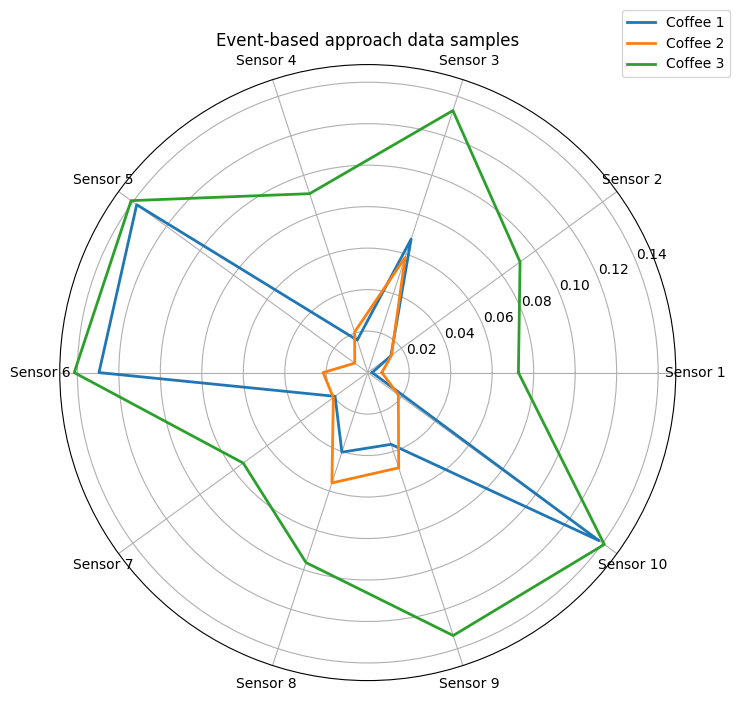

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = [f'Sensor {i}' for i in range(1, 11)]
data_sample_1 = p10x_data_l2[201].tolist()
data_sample_2 = p10x_data_l2[50].tolist()
data_sample_3 = p10x_data_l2[1750].tolist()

# Combine the data samples
data_samples = [data_sample_1, data_sample_2, data_sample_3]
sample_names = ['Coffee 1', 'Coffee 2', 'Coffee 3']

# Number of variables
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each data sample
for data, sample_name in zip(data_samples, sample_names):
    data += data[:1]  # Complete the loop
    ax.plot(angles, data, linewidth=2, label=sample_name)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
ax.title.set_text('Event-based approach data samples')

# Show
plt.show()


ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

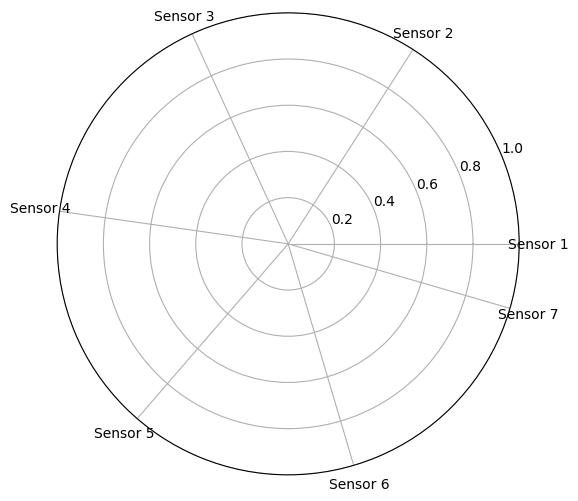

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 8', 'Sensor 9', 'Sensor 10']
values1 = p10x_data_l2[1]
values2 = p10x_data_l2[31]
values3 = p10x_data_l2[1777]

# Number of variables
num_vars = len(labels)

# Compute angle of each axis
angles = labels

# The plot is circular, so we need to "complete the loop"
values1 += values1[:1]
values2 += values2[:1]
values3 += values3[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each line
ax.plot(angles, values1, color='blue', linewidth=2, label='Coffe 1')
ax.plot(angles, values2, color='green', linewidth=2, label='Coffe 2')
ax.plot(angles, values3, color='red', linewidth=2, label='Coffe 3')

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show
plt.show()


## Data augmentation and synthetic interpolation

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import CubicSpline

# # Step 1: Generate initial data points
# x = np.array([0, 2, 4, 6, 8, 10])  # Initial data points
# y = np.sin(x)  # Synthetic signal using the sine function

# # Step 2: Use cubic spline interpolation to generate additional points within the range of initial data points
# x_interpolated = np.linspace(min(x), max(x), 100)  # 100 points for smooth interpolation within the range
# cs = CubicSpline(x, y)
# y_interpolated = cs(x_interpolated)

# # Step 3: Plot the original and interpolated signals
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, 'o', label='Original data points')
# plt.plot(x_interpolated, y_interpolated, '-', label='Interpolated signal')
# plt.scatter(x_interpolated, y_interpolated)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Synthetic Data Points within the Range of Existing Data using Cubic Spline Interpolation')
# plt.legend()
# plt.show()

In [ ]:
# def add_synthetic_data(input_X, input_y, add_noise='None'):

#     original_data = input_X
#     original_labels = input_y

#     num_samples = 30
#     desired_length = 50
#     selected_indices = np.random.choice(original_data.shape[0], num_samples, replace=False)
#     x_values = np.arange(original_data.shape[1])
#     new_data = []
#     new_labels = []

#     for idx in range(original_data.shape[0]):
#         f = interp1d(x_values, original_data[idx], kind='linear')
#         new_x_values = np.linspace(0, original_data.shape[1] - 1, desired_length)
#         interpolated_data = f(new_x_values)
#         new_data.append(interpolated_data)
#         new_labels.append(original_labels[idx])

#     new_data = np.array(new_data)
#     new_labels = np.array(new_labels)

#     print("Shape of new data:", new_data.shape)
#     print("Shape of new labels:", new_labels.shape)

    # def generate_synthetic_data2(data, num_new_samples):
    #     interpolated_data = []
    #     for sample in data:
    #         x = np.arange(len(sample))  # Assume x-values are indices
    #         f = interp1d(x, sample, kind='linear')  # Linear interpolation
    #         new_x = np.linspace(0, len(sample) - 1, num=num_new_samples)  # Generate 100 new points
    #         new_sample = f(new_x)
    #         interpolated_data.append(new_sample)

    # interpolated_data = np.array(interpolated_data)

    # # Copy labels from the original data
    # interpolated_labels = np.tile(original_labels, (len(interpolated_data), 1))  # Repeat labels for each new sample

    # # Now you have more data points (interpolated_data) with corresponding labels (interpolated_labels)
    # print("Interpolated Data Shape:", interpolated_data.shape)
    # print("Interpolated Labels Shape:", interpolated_labels.shape)

    # def generate_synthetic_data(data, num_new_samples):
    #     new_data = []
    #     for sample in data:
    #         for sublist in sample:
    #             x = np.arange(len(sublist))
    #             f = interp1d(x, sublist, kind='cubic')
    #             x_new = np.linspace(0, len(sublist)-1, num=num_new_samples)
    #             new_sublist = f(x_new)
    #             new_data.append(new_sublist)
    #     new_data = np.array(new_data).reshape(data.shape[0], data.shape[1], num_new_samples)
    #     rescaled_new_data = np.array(rescale_3d_list(new_data, target_length=50))

        # return rescaled_new_data

    # if add_noise != 'None':
    #     noise = np.random.normal(0, 0.002, mini_arr_2d_multi_ch.shape)
    #     input_X = input_X + noise

    # new_labels = input_y
    # synthetic_data = generate_synthetic_data(normalized_array, len(input_X))
    # new_labels += input_y
    # synthetic_data2 = generate_synthetic_data(normalized_array, len(input_X))
    # new_labels += input_y

    # merged_data = np.concatenate((input_X, new_data), axis=0)
    # merged_labels = np.concatenate((input_y, new_labels), axis=0)
    # merged_arr_2d = merged_data.reshape(len(merged_data), 500)

    # print("Merged data shape:", merged_arr_2d.shape)

    # return merged_arr_2d, new_labels

# plt.plot(full_dataset[41][2])
# plt.xlim(0, 60)
# plt.xlabel('Sample number')
# plt.ylabel('Single channel output value')
# plt.title('First type of data samples - long')
# plt.show()
# plt.xlabel('Sample number')
# plt.ylabel('Single channel output value')
# plt.title('Second type of data samples - short')
# plt.xlim(0, 60)
# plt.plot(mini_dataset[41][2])
# plt.show()

# Preprocessing

In [ ]:
def preprocess_dataset(X_input, y_input, smote_obj=None):

    # if 'full' in X_input:
    #     y_input = labels
    # elif datatype == 'mini':
    #     X_input = mini_2d_multi_ch
    #     y_input = labels
    # elif datatype == 'p10x':
    #     X_input = p10x_data
    #     y_input = p10x_labels
    # else:
    #     raise ValueError("Used datatype not recoginized.")

    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.3, random_state=42)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    if smote_obj:
        X_train, y_train = smote_obj.fit_resample(X_train, y_train)
    # X_train, y_train = add_synthetic_data(X_train, y_train)
    return (X_train, X_test, y_train, y_test)

def group_training(dataset_label, dataset_tuple, nr_of_trainings=3):
    """Train 10 algorithms with the same data and return list of results"""

    def one_training(classifier):
        if classifier == 'cnn_flag':
            cnn_input = (dataset_tuple, None)
            f1, acc = do_cnn(cnn_input)
            acc_score_list.append(acc)
            f1_score_list.append(f1)
        else:
            best_f1 = 0.0
            for i in range(nr_of_trainings):
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_test)
                f1 = f1_score(y_test, y_pred, average='macro')
                if f1 > best_f1:
                    best_f1 = f1
                    acc = accuracy_score(y_test, y_pred)
            acc_score_list.append(acc)
            f1_score_list.append(best_f1)
        # print("Precision:", precision_score(y_test, y_pred, average='macro'))
        # print("Recall:", recall_score(y_test, y_pred, average='macro'))
        # print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    classifier_list = [
    LogisticRegression(max_iter=200),
    SVC(kernel='poly'),
    KNeighborsClassifier(n_neighbors=3),
    # DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    SGDClassifier(max_iter=1000, tol=1e-3),
    ExtraTreesClassifier(n_estimators=100),
    'cnn_flag'
    ]

    f1_score_list = []
    acc_score_list = []
    dataset_labels.append(dataset_label)
    X_train, X_test, y_train, y_test = dataset_tuple

    for classifier in classifier_list:
        one_training(classifier)

    f1_scores_list.append(f1_score_list)
    acc_scores_list.append(acc_score_list)

    print(f1_score_list)
    return

def group_result(description = ""):
    fig, ax = plt.subplots(figsize=(16, 8))
    cax = ax.matshow(f1_scores_list, cmap='rainbow', vmin=0, vmax=1)

    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classifier_labels)))
    ax.set_yticks(np.arange(len(dataset_labels)))
    ax.set_xticklabels(classifier_labels, rotation=-90)
    ax.set_yticklabels(dataset_labels)

    for i in range(len(dataset_labels)):
        for j in range(len(classifier_labels)):
            ax.text(j, i, f'{f1_scores_list[i][j]:.2f}', ha='center', va='center', color='black')

    plt.xlabel('Classifier')
    plt.ylabel('Dataset', rotation=-90)
    plt.title(description)

    plt.show()

In [ ]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)  # Use sigmoid for multi-label classification
        return out

def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Forward pass
        outputs = model(X_test_tensor)
        # Convert outputs to predicted class labels
        predicted = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(y_test_tensor, dim=1)

        # Convert tensors to numpy arrays
        predicted = predicted.numpy()
        true_labels = true_labels.numpy()

        # Calculate evaluation metrics
        accuracy = accuracy_score(true_labels, predicted)
        precision = precision_score(true_labels, predicted, average='macro')
        recall = recall_score(true_labels, predicted, average='macro')
        f1 = f1_score(true_labels, predicted, average='macro')
        conf_matrix = confusion_matrix(true_labels, predicted)

        # Print evaluation metrics
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

        return f1, accuracy

def do_cnn(dataset_tuple):

    tmp, _ = dataset_tuple
    X_train, X_test, y_train, y_test = tmp
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

    y_train = [x - 1 for x in y_train]
    y_test = [x - 1 for x in y_test]
    y_validate = [x - 1 for x in y_validate]

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_validate = np.array(y_validate)
    X_test = np.array(X_test)
    X_train = np.array(X_train)
    X_validate = np.array(X_validate)

    one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
    y_train_onehot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = one_hot_encoder.transform(y_test.reshape(-1, 1))
    y_validate_onehot = one_hot_encoder.transform(y_validate.reshape(-1, 1))

    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train_onehot, dtype=torch.float)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test_onehot, dtype=torch.float)
    y_validate_tensor = torch.tensor(y_validate, dtype=torch.float)

    input_size = X_train_tensor.shape[1]
    hidden_size = int(X_train_tensor.shape[1] * 0.6)
    output_size = y_train_tensor.shape[1]
    model = FullyConnectedNN(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss for every epoch
        # if epoch % 100 == 0:
            # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Call the evaluation function after training
    return evaluate_model(model, X_test_tensor, y_test_tensor)


# Algorithm Training

Preparing datasets...
Starting training phase...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3552
Precision: 0.1184
Recall: 0.3333
F1 Score: 0.1747
Confusion Matrix:
[[ 0 64  0]
 [ 0 65  0]
 [ 0 54  0]]
[0.3872558448333096, 0.5810627088880076, 0.5467825167638861, 0.6025101359715143, 0.6092587991718427, 0.43298067717796923, 0.3290635308010554, 0.431311236189285, 0.614673235883335, 0.1747311827956989]
Accuracy: 0.2105
Precision: 0.1528
Recall: 0.1905
F1 Score: 0.1694
Confusion Matrix:
[[3 4 0]
 [4 1 2]
 [2 3 0]]
[0.30158730158730157, 0.5074925074925075, 0.332001332001332, 0.6904761904761904, 0.7083333333333334, 0.6474747474747474, 0.38894438894438893, 0.32575757575757575, 0.6325757575757577, 0.16944444444444443]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.3684
Precision: 0.1228
Recall: 0.3333
F1 Score: 0.1795
Confusion Matrix:
[[0 7 0]
 [0 7 0]
 [0 5 0]]
[0.1794871794871795, 0.4525474525474526, 0.3151515151515151, 0.6986346986346986, 0.5793650793650793, 0.5851851851851853, 0.5391275391275391, 0.25071225071225073, 0.6919191919191919, 0.1794871794871795]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.4211
Precision: 0.3852
Recall: 0.4762
F1 Score: 0.4048
Confusion Matrix:
[[2 4 1]
 [3 1 3]
 [0 0 5]]
[0.47008547008547, 0.5341880341880342, 0.4402264402264402, 0.6367521367521367, 0.611111111111111, 0.37543859649122807, 0.7474747474747474, 0.2638888888888889, 0.6367521367521367, 0.4047619047619048]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3552
Precision: 0.1184
Recall: 0.3333
F1 Score: 0.1747
Confusion Matrix:
[[ 0 64  0]
 [ 0 65  0]
 [ 0 54  0]]
[0.31526877680723836, 0.36300778455245947, 0.41418182296392736, 0.4376125269780044, 0.44198835676108406, 0.40263016639828236, 0.3240400326797385, 0.2383946592144077, 0.4594760768910077, 0.1747311827956989]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2632
Precision: 0.1778
Recall: 0.2381
F1 Score: 0.2034
Confusion Matrix:
[[3 4 0]
 [5 2 0]
 [1 4 0]]
[0.2212121212121212, 0.5074925074925075, 0.327485380116959, 0.5313131313131313, 0.41269841269841273, 0.43611111111111106, 0.31196581196581197, 0.19444444444444445, 0.5867465867465866, 0.20343137254901963]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase

Accuracy: 0.3684
Precision: 0.1228
Recall: 0.3333
F1 Score: 0.1795
Confusion Matrix:
[[0 7 0]
 [0 7 0]
 [0 5 0]]
[0.12121212121212122, 0.47575757575757577, 0.327485380116959, 0.5313131313131313, 0.4545454545454546, 0.3769063180827887, 0.24175824175824176, 0.18253968253968253, 0.5238095238095237, 0.1794871794871795]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.3158
Precision: 0.2222
Recall: 0.3619
F1 Score: 0.2594
Confusion Matrix:
[[0 3 4]
 [1 2 4]
 [0 1 4]]
[0.32478632478632474, 0.38974358974358975, 0.4509803921568627, 0.4878454878454878, 0.4804232804232805, 0.26746031746031745, 0.373015873015873, 0.1794871794871795, 0.48686868686868684, 0.25942684766214175]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3789
Precision: 0.1263
Recall: 0.3333
F1 Score: 0.1832
Confusion Matrix:
[[  0 165   0]
 [  0 208   0]
 [  0 176   0]]
[0.2692313489641035, 0.6754480363528249, 0.85151863357595, 0.9366134806812774, 0.9144930244518444, 0.7421303376560938, 0.4116949513448989, 0.48485249559795957, 0.9509083687790422, 0.1831792162043153]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3789
Precision: 0.1263
Recall: 0.3333
F1 Score: 0.1832
Confusion Matrix:
[[  0 165   0]
 [  0 208   0]
 [  0 176   0]]
[0.1831792162043153, 0.6450521473565743, 0.8553002575737995, 0.9328220667785119, 0.896462884017017, 0.70774398476737, 0.40410149106091975, 0.28911856067699365, 0.9439034180650454, 0.1831792162043153]
Accuracy: 0.3424
Precision: 0.2274
Recall: 0.3330
F1 Score: 0.2702
Confusion Matrix:
[[ 76  88   1]
 [ 95 112   1]
 [ 65 111   0]]
[0.5096702183190938, 0.7026043238367802, 0.8235965841387528, 0.9126754696805799, 0.8647325922232435, 0.611008754004969, 0.3723027375201289, 0.5488666261082024, 0.9264213746680978, 0.2702171994547991]


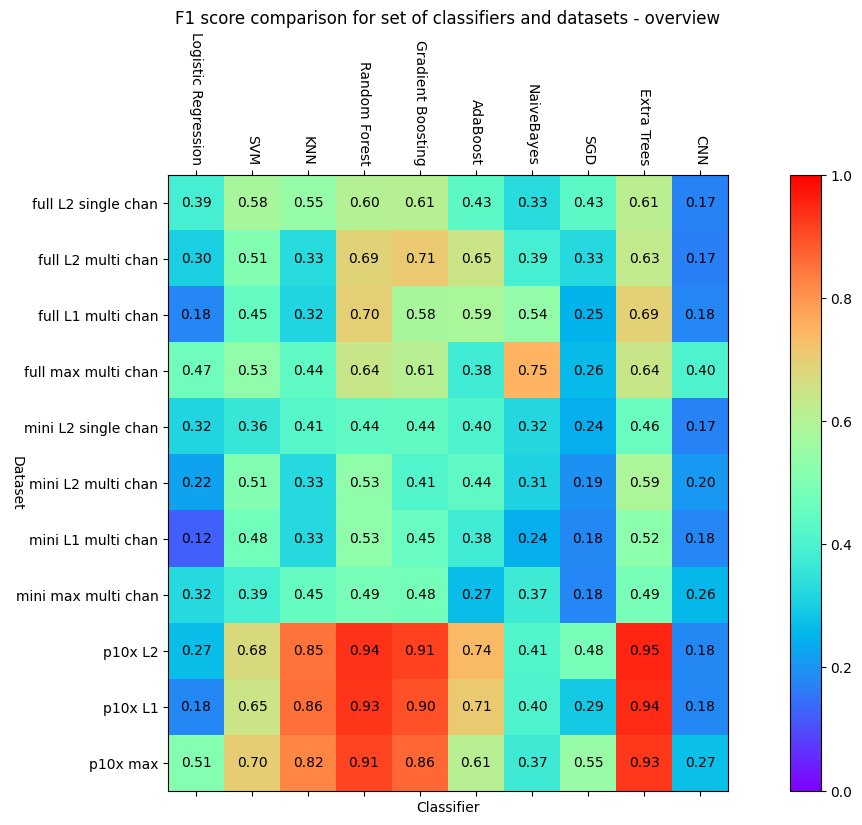

In [ ]:
# classifier_labels = ["Logistic Regression", "SVM", "KNN", "Random Forest", "Gradient Boosting", "AdaBoost", "NaiveBayes", "SGD", "Extra Trees", "CNN"]
classifier_labels = ["SVM1, SVM2, SVM3, SVM4    "]
dataset_labels = []
f1_scores_list = []
acc_scores_list = []

smote = SMOTE()
smote_borderline = BorderlineSMOTE()
smote_adasyn = ADASYN()
smote_enn = SMOTEENN()
smote_tomek = SMOTETomek()

dataset_list = []

print("Preparing datasets...")

dataset_list.append((preprocess_dataset(full_2d_single_ch, single_ch_labels), 'full L2 single chan'))
dataset_list.append((preprocess_dataset(full_2d_multi_ch_l2, standard_labels), 'full L2 multi chan'))
dataset_list.append((preprocess_dataset(full_2d_multi_ch_l1, standard_labels), 'full L1 multi chan'))
dataset_list.append((preprocess_dataset(full_2d_multi_ch_max, standard_labels), 'full max multi chan'))


dataset_list.append((preprocess_dataset(mini_2d_single_ch, single_ch_labels), 'mini L2 single chan'))
dataset_list.append((preprocess_dataset(mini_2d_multi_ch_l2, standard_labels), 'mini L2 multi chan'))
dataset_list.append((preprocess_dataset(mini_2d_multi_ch_l1, standard_labels), 'mini L1 multi chan'))
dataset_list.append((preprocess_dataset(mini_2d_multi_ch_max, standard_labels), 'mini max multi chan'))

dataset_list.append((preprocess_dataset(p10x_data_l2, p10x_labels), 'p10x L2'))
dataset_list.append((preprocess_dataset(p10x_data_l1, p10x_labels), 'p10x L1'))
dataset_list.append((preprocess_dataset(p10x_data_max, p10x_labels), 'p10x max'))

print("Starting training phase...")
for dataset, dataset_decription in dataset_list:
    group_training(dataset_decription, dataset)

group_result("F1 score comparison for set of classifiers and datasets - overview")

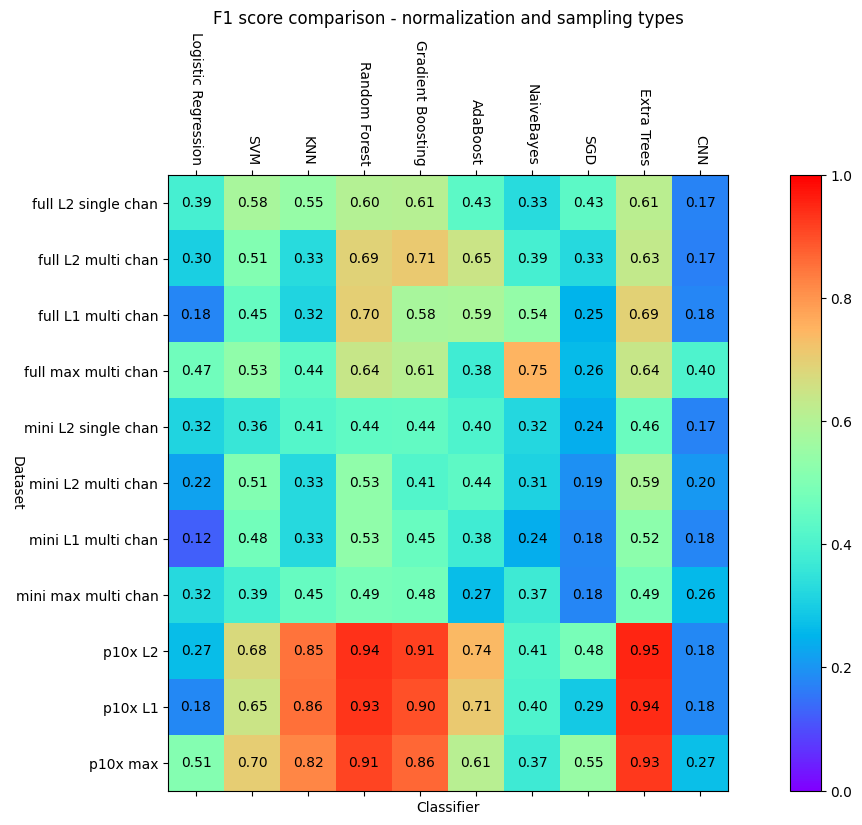

In [ ]:
group_result("F1 score comparison - normalization and sampling types")

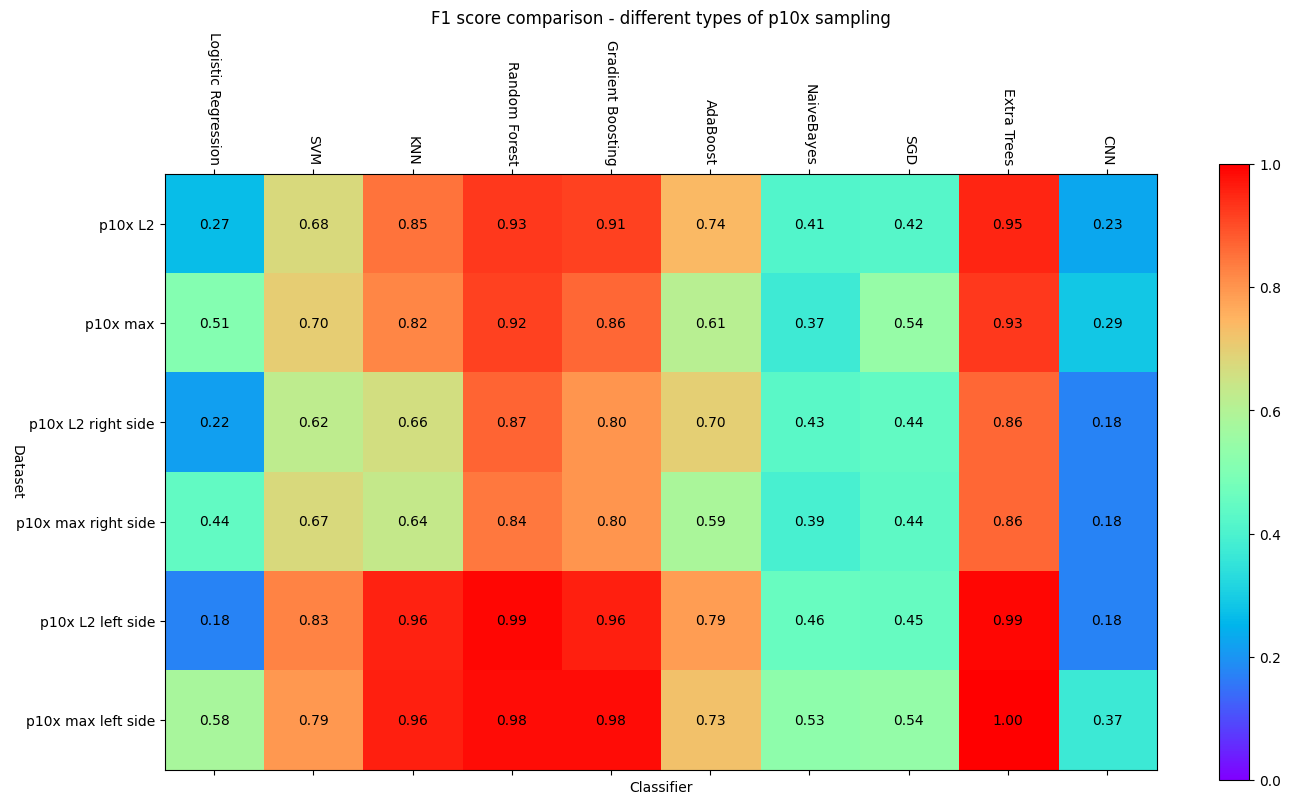

In [ ]:
group_result("F1 score comparison - different types of p10x sampling")

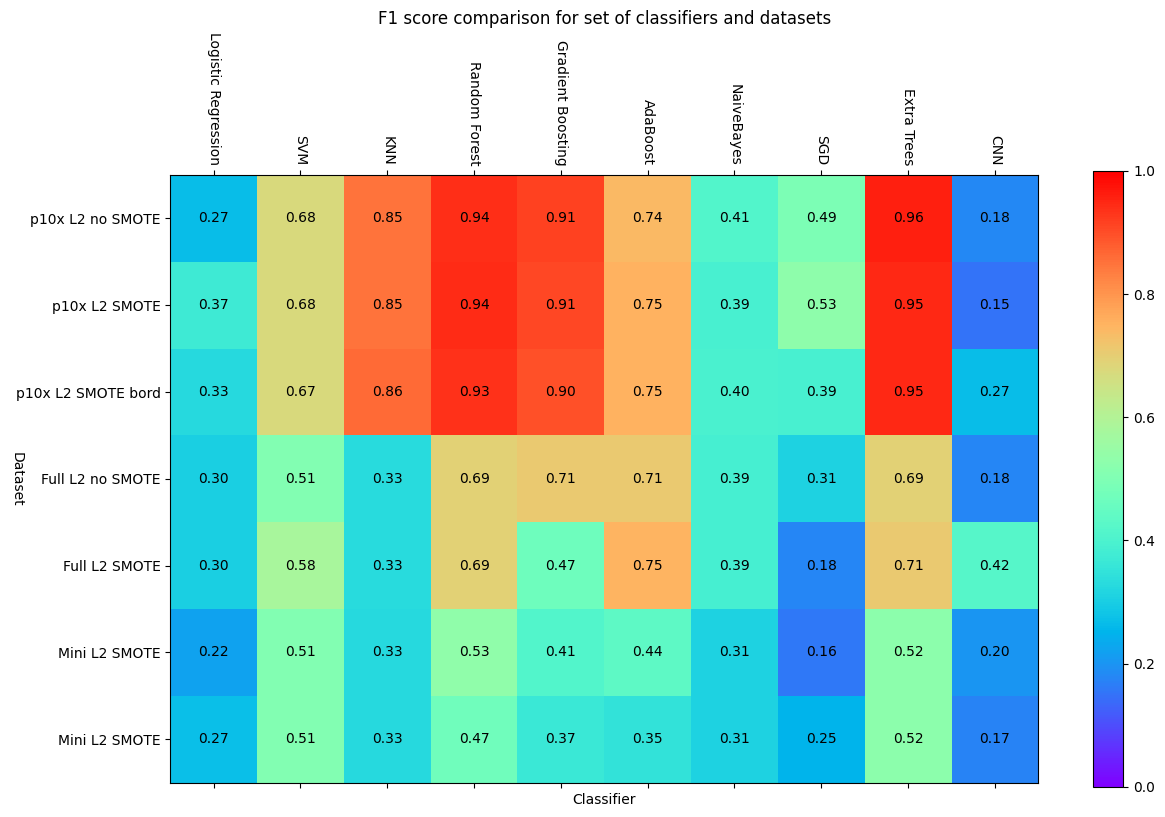

In [ ]:
group_result()

# Deep learning

# Datasets archive

In [ ]:
# dataset_list.append((preprocess_dataset('p10x'), 'p10x L2 no SMOTE'))
# dataset_list.append((preprocess_dataset('p10x', smote_obj=smote), 'p10x L2 SMOTE'))
# dataset_list.append((preprocess_dataset('p10x', smote_obj=smote_borderline), 'p10x L2 SMOTE bord'))

# dataset_list.append((preprocess_dataset('full',), 'Full L2 no SMOTE'))
# dataset_list.append((preprocess_dataset('full', smote_obj=smote), 'Full L2 SMOTE'))

# dataset_list.append((preprocess_dataset('mini',), 'Mini L2 SMOTE'))
# dataset_list.append((preprocess_dataset('mini', smote_obj=smote), 'Mini L2 SMOTE'))

# dataset_list.append((preprocess_dataset(full_2d_single_ch, single_ch_labels), 'full L2 single chan'))

# -------------------------------------------------------------------------------------------------------

# dataset_list.append((preprocess_dataset(full_2d_single_ch, single_ch_labels), 'full L2 single chan'))
# dataset_list.append((preprocess_dataset(full_2d_multi_ch_l2, standard_labels), 'full L2 multi chan'))
# dataset_list.append((preprocess_dataset(full_2d_multi_ch_l1, standard_labels), 'full L1 multi chan'))
# dataset_list.append((preprocess_dataset(full_2d_multi_ch_max, standard_labels), 'full max multi chan'))
# # dataset_list.append((preprocess_dataset(rescaled_full, standard_labels), 'full multi chan not norm.'))


# dataset_list.append((preprocess_dataset(mini_2d_single_ch, single_ch_labels), 'mini L2 single chan'))
# dataset_list.append((preprocess_dataset(mini_2d_multi_ch_l2, standard_labels), 'mini L2 multi chan'))
# dataset_list.append((preprocess_dataset(mini_2d_multi_ch_l1, standard_labels), 'mini L1 multi chan'))
# dataset_list.append((preprocess_dataset(mini_2d_multi_ch_max, standard_labels), 'mini max multi chan'))
# # dataset_list.append((preprocess_dataset(rescaled_mini, standard_labels), 'mini multi chan not norm.'))

# dataset_list.append((preprocess_dataset(p10x_data_l2, p10x_labels), 'p10x L2'))
# dataset_list.append((preprocess_dataset(p10x_data_l1, p10x_labels), 'p10x L1'))
# dataset_list.append((preprocess_dataset(p10x_data_max, p10x_labels), 'p10x max'))
# # dataset_list.append((preprocess_dataset(p10x_data_normless, p10x_labels), 'p10x not norm.'))

# -------------------------------------------------------------------------------------------------------

# dataset_list.append((preprocess_dataset(p10x_data_l2, p10x_labels), 'p10x L2'))
# dataset_list.append((preprocess_dataset(p10x_data_max, p10x_labels), 'p10x max'))
# dataset_list.append((preprocess_dataset(p10xx_data_l2, p10x_labels_half), 'p10x L2 right side'))
# dataset_list.append((preprocess_dataset(p10xx_data_max, p10x_labels_half), 'p10x max right side'))
# dataset_list.append((preprocess_dataset(pp10x_data_l2, p10x_labels_half), 'p10x L2 left side'))
# dataset_list.append((preprocess_dataset(pp10x_data_max, p10x_labels_half), 'p10x max left side'))
